In [1]:
import unittest
import numpy as np
import treecorr
import healpy as hp
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time 
import os
import coord
from numba import jit, njit


sys.path.insert(1,'../src/')

from CosmoFuse.correlations import Correlation_CPU
from CosmoFuse.utils import pixel2RaDec

In [2]:
nside = 512
radius_patch = 120/60
radius_filter = 5 * radius_patch
theta_Q = np.radians(radius_filter)
nbins = 20
n_patches = 992
des_map = hp.read_map("./data/DESY3_Mask.fits")


map_inds = np.where(des_map!=0)[0]
phi_center = np.loadtxt("/e/ocean1/users/dgebauer/patch_centers/patch_center_original_phi.dat")[:n_patches]
theta_center = np.loadtxt("/e/ocean1/users/dgebauer/patch_centers/patch_center_original_theta.dat")[:n_patches]


npix = hp.nside2npix(nside)

mintheta = 20
maxtheta = 230

mintheta = mintheta/60/180*np.pi
maxtheta = maxtheta/60/180*np.pi

shear_maps = np.load("./data/shear_maps.npy")        

min_theta = 20
max_theta = 230

w = np.ones_like(shear_maps[0,0])

binedges=np.geomspace(min_theta,max_theta,nbins+1)
bincenters=np.exp(np.diff(np.log(binedges))/2+np.log(binedges[:-1]))

binedges=np.geomspace(mintheta,maxtheta,nbins+1)
bincenters=np.exp(np.diff(np.log(binedges))/2+np.log(binedges[:-1]))/np.pi*180*60

In [3]:
%%time

def get_pairs_coord(nside, patch_inds, ra, dec, binedges, nbins):
    all_inds, exp2theta1_temp, exp2theta2_temp = [], [], []
    cos_vartheta = np.cos(np.subtract.outer(ra, ra))*np.multiply.outer(np.cos(dec),np.cos(dec)) + np.multiply.outer(np.sin(dec),np.sin(dec))
    dist = np.arccos(np.triu(cos_vartheta, k=1))    
    #dist = np.arccos(cos_vartheta)    
    
    north_pole = coord.CelestialCoord(0*coord.radians, 90*coord.degrees)

    for i in range(nbins):
        inds = np.where((dist > binedges[i]) & (dist < binedges[i+1]))
        pair_inds = np.array([patch_inds[inds[0]], patch_inds[inds[1]]])
        ra_pairs1 = ra[inds[0]]
        dec_pairs1 = dec[inds[0]]
        ra_pairs2 = ra[inds[1]]
        dec_pairs2 = dec[inds[1]]
        
        c1 = [coord.CelestialCoord(r*coord.radians, d*coord.radians) for (r,d) in zip(ra_pairs1, dec_pairs1)]
        c2 = [coord.CelestialCoord(r*coord.radians, d*coord.radians) for (r,d) in zip(ra_pairs2, dec_pairs2)]
        
        all_inds.append(pair_inds)
        
        for j, _ in enumerate(ra_pairs1):
            theta1 = 90*coord.degrees - c1[j].angleBetween(north_pole, c2[j])
            theta2 = 90*coord.degrees - c2[j].angleBetween(north_pole, c1[j])
            exp2theta1 = np.cos(2*theta1) + 1j * np.sin(2*theta1)
            exp2theta2 = np.cos(2*theta2) + 1j * np.sin(2*theta2)

            exp2theta1_temp.append(exp2theta1)
            exp2theta2_temp.append(exp2theta2)
    
    exp2theta = np.array([exp2theta1_temp, exp2theta2_temp])
    return all_inds, exp2theta, dist

pair_inds, pair_exp2theta, bins, dist = [], [], [], []

def get_pairs_coord_mult(i):
    vec = hp.ang2vec(theta_center[i], phi_center[i])
    patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
    pix_inds = np.intersect1d(patch_inds, map_inds)
    ra, dec = pixel2RaDec(pix_inds, nside)
    inds, exp2theta, d = get_pairs_coord(nside, pix_inds, ra, dec, binedges, nbins)
    ninds = np.array([len(inds[i][0]) for i in range(nbins)])
    all_inds = np.zeros((2,ninds.sum()))
    for bin in range(nbins):
        all_inds[0,np.sum(ninds[:bin]):np.sum(ninds[:bin+1])] = inds[bin][0]
        all_inds[1,np.sum(ninds[:bin]):np.sum(ninds[:bin+1])] = inds[bin][1]
    
    return all_inds.astype(int), exp2theta, ninds, d

with Pool(100) as p:
    result = p.map(get_pairs_coord_mult, range(n_patches))

for i in range(n_patches):
    pair_inds.append(result[i][0])
    pair_exp2theta.append(result[i][1])
    bins.append(result[i][2])
    dist.append(result[i][3])
    
@njit(fastmath=False)
def xipm_jit_coord(inds, exp2theta, bin_inds, g11, g21, g12, g22):

    xip, xim = np.zeros(nbins, dtype='c8'), np.zeros(nbins, dtype='c8')
    
    g1 = ((-g11[inds[0]]) + 1j* g21[inds[0]]) * exp2theta[0] # minus in front of all g1?
    g2 = ((-g12[inds[1]]) + 1j*g22[inds[1]]) * exp2theta[1]

    bin_edges = np.append([0], np.cumsum(bin_inds))
    
    for bin in range(nbins):
        xip[bin] = np.sum(g1[bin_edges[bin]:bin_edges[bin+1]] * np.conjugate(g2[bin_edges[bin]:bin_edges[bin+1]]))/(bin_inds[bin])
        xim[bin] = np.sum(g1[bin_edges[bin]:bin_edges[bin+1]] * g2[bin_edges[bin]:bin_edges[bin+1]])/(bin_inds[bin])
        

    return np.real(xip), np.real(xim)


def get_xipm_coord(i):
    xip, xim = xipm_jit_coord(pair_inds[i], pair_exp2theta[i], bins[i], shear_maps[0,0], shear_maps[0,1], shear_maps[0,0], shear_maps[0,1])
    return xip, xim


CPU times: user 1min 8s, sys: 1min 22s, total: 2min 30s
Wall time: 15min 3s


In [3]:
cos2phi_1, sin2phi_1, cos2phi_2, sin2phi_2 = [], [], [], []

for i in range(n_patches):
    cos2phi_1.append(np.real(pair_exp2theta[i][0]))
    sin2phi_1.append(np.imag(pair_exp2theta[i][0]))
    cos2phi_2.append(np.real(pair_exp2theta[i][1]))
    sin2phi_2.append(np.imag(pair_exp2theta[i][1]))
    
@njit(fastmath=False)
def xipm_new(inds, cos2phi_1, sin2phi_1, cos2phi_2, sin2phi_2, bin_inds, g11, g21, g12, g22, w1, w2, nbins):
    
    xip, xim = np.zeros(nbins, dtype=np.float32), np.zeros(nbins, dtype=np.float32)

    gt1 = - g11[inds[0]]*cos2phi_1 - g21[inds[0]]*sin2phi_1
    gx1 = - g11[inds[0]]*sin2phi_1 + g21[inds[0]]*cos2phi_1
    gt2 = - g12[inds[1]]*cos2phi_2 - g22[inds[1]]*sin2phi_2
    gx2 = - g12[inds[1]]*sin2phi_2 + g22[inds[1]]*sin2phi_2

    gt = gt1*gt2
    gx = gx1*gx2
    
    bin_edges = np.append([0], np.cumsum(bin_inds)).astype('int')
    
    for bin in range(nbins):
        xip[bin] = np.sum(gt[bin_edges[bin]:bin_edges[bin+1]]+gx[bin_edges[bin]:bin_edges[bin+1]])/(bin_inds[bin])
        xim[bin] = np.sum(gt[bin_edges[bin]:bin_edges[bin+1]]-gx[bin_edges[bin]:bin_edges[bin+1]])/(bin_inds[bin])

    return xip, xim

def get_xipm_new(i):
        return xipm_new(pair_inds[i], cos2phi_1[i], sin2phi_1[i], cos2phi_2[i], sin2phi_2[i], bins[i], shear_maps[0,0], shear_maps[0,1], shear_maps[0,0], shear_maps[0,1], w, w, nbins)

NameError: name 'pair_exp2theta' is not defined

In [8]:
xip_test, xim_test = [], []

for i in range(n_patches):
    a, b = get_xipm_new(i)
    xip_test.append(a)
    xim_test.append(b)
    
xip_test = np.array(xip_test)
xim_test = np.array(xim_test)

NameError: name 'get_xipm_new' is not defined

In [7]:
%%time
xip_coord, xim_coord = np.zeros((n_patches,nbins)), np.zeros((n_patches,nbins))

for i in range(n_patches):
    xip_coord[i,:], xim_coord[i,:] = get_xipm_coord(i)

CPU times: user 8.52 s, sys: 792 ms, total: 9.32 s
Wall time: 9.32 s


In [9]:
%%time
xip_treecorr = np.zeros((n_patches,nbins))
xim_treecorr = np.zeros((n_patches,nbins))


correlation = treecorr.GGCorrelation(nbins=nbins, min_sep=min_theta, max_sep=max_theta, sep_units='arcmin', brute=True, metric='Arc', bin_slop=0.)
for i in range(n_patches):
    vec = hp.ang2vec(theta_center[i], phi_center[i])
    patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
    pix_inds = np.intersect1d(patch_inds, map_inds)
    g11 = shear_maps[0,0,pix_inds]
    g21 = shear_maps[0,1,pix_inds]
    #g12 = shear_maps[1,0,pix_inds]
    #g22 = shear_maps[1,1,pix_inds]
    ra, dec = pixel2RaDec(pix_inds, nside)
    catalog1 = treecorr.Catalog(ra=ra, dec=dec, g1=g11, g2=g21, ra_units='rad', dec_units='rad', flip_g1=True)
    #catalog2 = treecorr.Catalog(ra=ra, dec=dec, g1=g12, g2=g22, ra_units='rad', dec_units='rad', flip_g1=True)
    correlation.process(catalog1)
    xip_treecorr[i,:] = correlation.xip
    xim_treecorr[i,:] = correlation.xim
    
rnom = correlation.rnom

CPU times: user 3h 22min 2s, sys: 2.38 s, total: 3h 22min 4s
Wall time: 1min 37s


In [3]:
%%time
corr = Correlation_CPU(nside, phi_center, theta_center, nbins=nbins, patch_size=radius_patch*60, theta_min=min_theta, theta_max=max_theta, mask=des_map, fastmath=False)
corr.load_maps(shear_maps[0,0], shear_maps[0,1], shear_maps[0,0], shear_maps[0,1], w, w)
corr.calculate_pairs_2PCF(threads=50)

CPU times: user 37.1 s, sys: 1min 9s, total: 1min 46s
Wall time: 1min 28s


In [6]:
%%time
xip, xim = corr.calculate_2PCF(threads=10)

CPU times: user 8.73 s, sys: 244 ms, total: 8.97 s
Wall time: 8.97 s


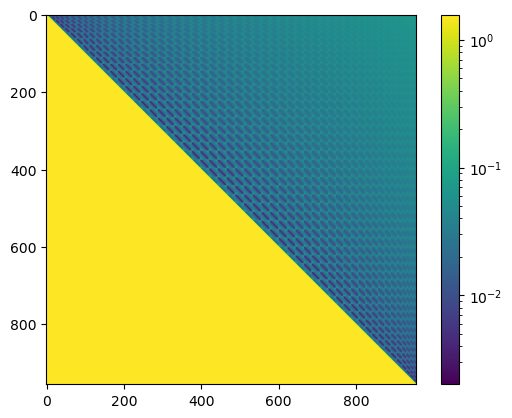

In [11]:
vec = hp.ang2vec(theta_center[0], phi_center[0])
patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
pix_inds = np.intersect1d(patch_inds, map_inds)
ra, dec = pixel2RaDec(pix_inds, nside)
cos_vartheta = np.cos(np.subtract.outer(ra, ra))*np.multiply.outer(np.cos(dec),np.cos(dec)) + np.multiply.outer(np.sin(dec),np.sin(dec))
dist = np.arccos(np.triu(cos_vartheta, k=1))
plt.imshow(dist, norm='log')
plt.colorbar()
distvec = []
relinds = []
for i in range(nbins):
    inds = np.where((dist > binedges[i]) & (dist < binedges[i+1]))
    distvec.append(dist[inds])
    relinds.append(inds)
distvec = np.concatenate(distvec)
relinds = np.concatenate(relinds, axis=1)
dec1 = dec[relinds[0]]
dec2 = dec[relinds[1]]
ra1 = ra[relinds[0]]
ra2 = ra[relinds[1]]

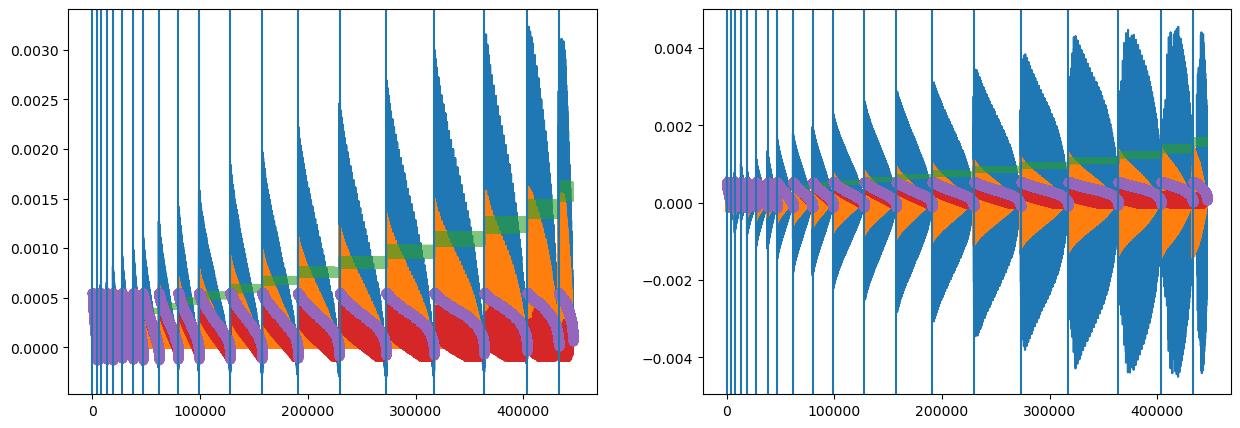

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
newbins = np.append([0], np.cumsum(bins[0]))
ax[0].plot(cos2phi_1[0]-cos2phi_2[0])
ax[0].plot(cos2phi_1[0]-corr.pair_cos_sin_2phi_1[0][0])
ax[1].plot(sin2phi_1[0]-sin2phi_2[0])
ax[1].plot(sin2phi_1[0]+corr.pair_cos_sin_2phi_1[0][1])
ax[0].plot(distvec/40, alpha=.6)
ax[1].plot(distvec/40, alpha=.6)
ax[0].plot(dec2/100)
ax[0].plot(dec1/100, 'o')
ax[1].plot(dec2/100)
ax[1].plot(dec1/100, 'o')
for i in range(nbins):
    ax[0].axvline(newbins[i])
    ax[1].axvline(newbins[i])

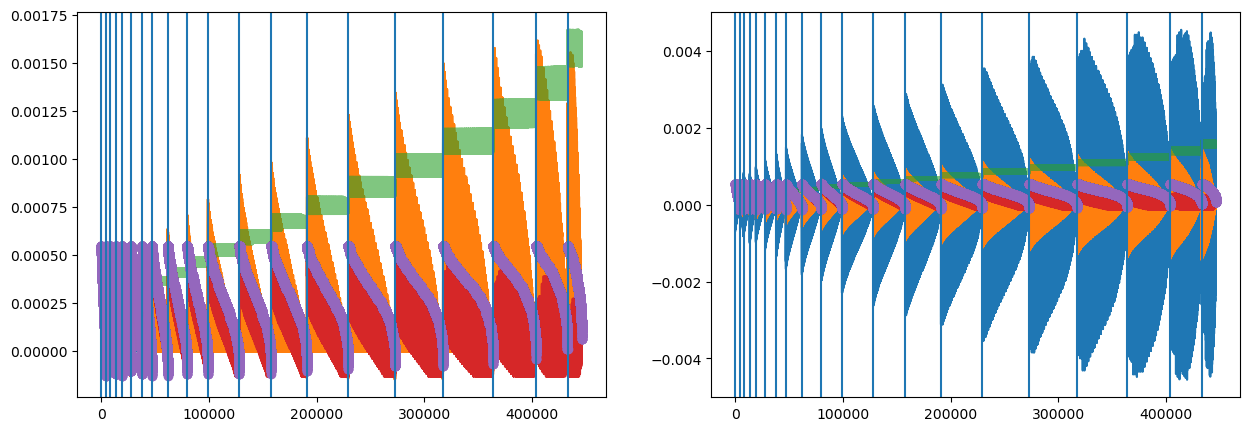

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
newbins = np.append([0], np.cumsum(bins[0]))

ax[0].plot(corr.pair_cos_sin_2phi_1[0][0]-corr.pair_cos_sin_2phi_2[0][0])
ax[0].plot(cos2phi_1[0]-corr.pair_cos_sin_2phi_1[0][0])

ax[1].plot(corr.pair_cos_sin_2phi_1[0][1]-corr.pair_cos_sin_2phi_2[0][1])
ax[1].plot(sin2phi_1[0]+corr.pair_cos_sin_2phi_1[0][1])

ax[0].plot(distvec/40, alpha=.6)
ax[1].plot(distvec/40, alpha=.6)
ax[0].plot(dec2/100)
ax[0].plot(dec1/100, 'o')
ax[1].plot(dec2/100)
ax[1].plot(dec1/100, 'o')
for i in range(nbins):
    ax[0].axvline(newbins[i])
    ax[1].axvline(newbins[i])

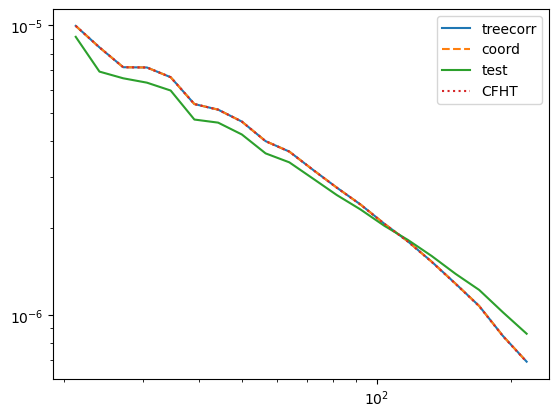

In [14]:
plt.loglog(rnom, xip_coord.mean(axis=0), label="treecorr")
plt.loglog(rnom, xip_treecorr.mean(axis=0), label="coord", ls='--')
plt.loglog(rnom, xip_test.mean(axis=0), label="test")
plt.loglog(rnom, xip.mean(axis=0), label="CFHT", ls='dotted')
plt.legend()

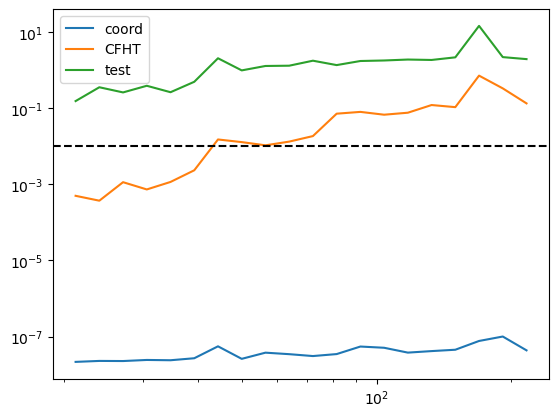

In [15]:
plt.loglog(rnom, np.abs(1-(xip_coord/xip_treecorr)).mean(axis=0), label="coord")
plt.loglog(rnom, np.abs(1-(xip/xip_treecorr)).mean(axis=0), label="CFHT")
plt.loglog(rnom, np.abs(1-(xip_test/xip_treecorr)).mean(axis=0), label="test")
plt.axhline(0.01, ls='--', c='k')

plt.legend()

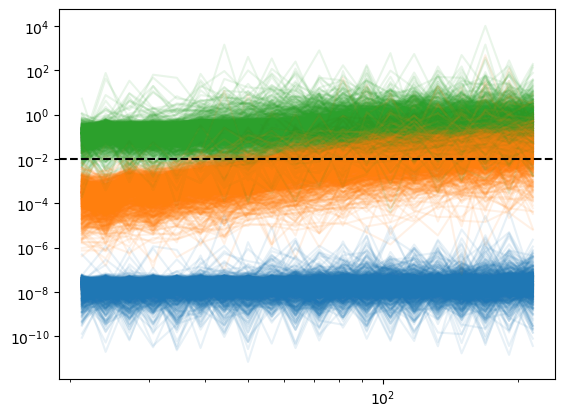

In [20]:
for i in range(n_patches):
    plt.loglog(rnom, np.abs(1-(xip_coord/xip_treecorr))[i], label="coord", c='C0', alpha=.1)
    plt.loglog(rnom, np.abs(1-(xip_test/xip_treecorr))[i], label="test", c='C2', alpha=.1)
    plt.loglog(rnom, np.abs(1-(xip/xip_treecorr))[i], label="CFHT", c='C1', alpha=.1)
plt.axhline(0.01, ls='--', c='k')
#plt.legend()

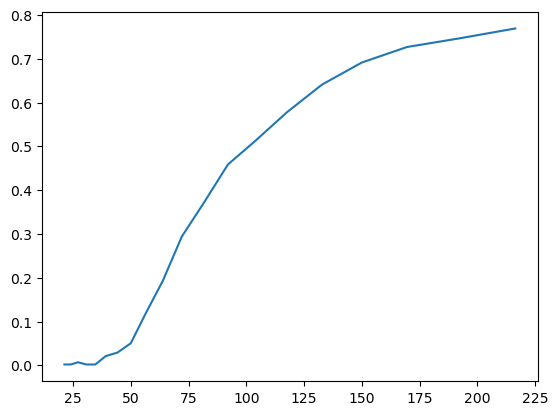

In [22]:
a,b = np.where(np.abs(1-(xip/xip_treecorr))>0.01)
outfrac = np.bincount(b)/n_patches
plt.plot(rnom, outfrac)

In [33]:
np.max(np.abs(1-(xip_coord/xip_treecorr)))


4.3464942147020125e-05